In [1]:
# Set path variables
import os
import sys

cwd = os.getcwd()
project_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(project_dir)

data_path = os.path.join(project_dir, 'data/')
print(project_dir)
print(data_path)

/home/seuh/Tagging-Music-Sequences
/home/seuh/Tagging-Music-Sequences/data/


In [2]:
import re
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from tqdm import tqdm
import torch
import torchaudio
import torchaudio.transforms
from sklearn.model_selection import train_test_split

from src import audio_util

# Preprocessing

## Label data

In [3]:
# Read metadata file gtzan
feature_path = data_path + 'gtzan/features_30_sec.csv'
gtzan_metadata_df = pd.read_csv(feature_path)

# Read metadata file mtat
annotations_path = data_path + 'mtat/annotations_final.csv'
mtat_metadata_df = pd.read_csv(annotations_path, quotechar='"', delim_whitespace=True)

# Specify cols to keep
gtzan_metadata_df = gtzan_metadata_df[['filename', 'label']]
mtat_metadata_df = mtat_metadata_df.drop('clip_id', axis=1)

In [4]:
gtzan_metadata_df.head()

,filename,label
0,blues.00000.wav,blues
1,blues.00001.wav,blues
2,blues.00002.wav,blues
3,blues.00003.wav,blues
4,blues.00004.wav,blues


In [5]:
# Define a function to change filename to match our folder structure
def apply_regex(filename):
    match = re.match(r'([^\.]+)\.\d+\.wav', filename)
    if match:
        genre = match.group(1)  
        return f"gtzan/genres_original/{genre}/{filename}"
    return filename

gtzan_metadata_df['filename'] = gtzan_metadata_df['filename'].apply(apply_regex)

In [6]:
mtat_metadata_df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


In [7]:
# adjust path name to be consistent with other df before concatenating
mtat_metadata_df['mp3_path'] = ["mtat/"]*len(mtat_metadata_df)+mtat_metadata_df['mp3_path'] 

In [8]:
gtzan_metadata_df.label.value_counts()

label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64

In [9]:
# get dummies for labels
dummies = pd.get_dummies(gtzan_metadata_df['label'])
dummies

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,True,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,False,False,False,True
996,False,False,False,False,False,False,False,False,False,True
997,False,False,False,False,False,False,False,False,False,True
998,False,False,False,False,False,False,False,False,False,True


In [10]:
# join dummies with original and drop label cols (one hot encoding)
gtzan_metadata_df.drop('label', axis=1, inplace=True)
gtzan_metadata_df = gtzan_metadata_df.join(dummies)

In [11]:
# check null data
gtzan_metadata_df.isnull().sum()

filename     0
blues        0
classical    0
country      0
disco        0
hiphop       0
jazz         0
metal        0
pop          0
reggae       0
rock         0
dtype: int64

In [12]:
# check null data
mtat_metadata_df.isnull().sum().sum()

0

In [13]:
# check if all columns of gtzan are in mtat to insure consistency
gtzan_metadata_df.columns.tolist() in mtat_metadata_df.columns.tolist()

False

In [14]:
# Making column lists
mtat_col = set(mtat_metadata_df.columns.tolist())
gtzan_col = set(gtzan_metadata_df.columns.tolist())

In [15]:
# Finding cols that are not in mtat
gtzan_col - mtat_col

{'filename', 'hiphop'}

In [16]:
mtat_metadata_df.columns

Index(['no voice', 'singer', 'duet', 'plucking', 'hard rock', 'world',
       'bongos', 'harpsichord', 'female singing', 'clasical',
       ...
       'rap', 'metal', 'hip hop', 'quick', 'water', 'baroque', 'women',
       'fiddle', 'english', 'mp3_path'],
      dtype='object', length=189)

In [17]:
# Rename cols so that they match other df
mtat_metadata_df.rename(columns={'hip hop': 'hiphop', 'mp3_path':'filepath'}, inplace=True)
gtzan_metadata_df.rename(columns={'filename':'filepath'}, inplace=True)

In [18]:
# check if problem solved
mtat_col = set(mtat_metadata_df.columns.tolist())
gtzan_col = set(gtzan_metadata_df.columns.tolist())
gtzan_col - mtat_col

set()

In [19]:
for col in mtat_metadata_df.select_dtypes(include=['float']).columns:
    mtat_metadata_df[col] = mtat_metadata_df[col].astype('int64') 

In [20]:
mtat_metadata_df.dtypes

no voice      int64
singer        int64
duet          int64
plucking      int64
hard rock     int64
              ...  
baroque       int64
women         int64
fiddle        int64
english       int64
filepath     object
Length: 189, dtype: object

In [21]:
gtzan_metadata_df.dtypes

filepath     object
blues          bool
classical      bool
country        bool
disco          bool
hiphop         bool
jazz           bool
metal          bool
pop            bool
reggae         bool
rock           bool
dtype: object

Handling overlapping labels and typos in mtat data
- "female singing" and "female singer", "female voice" , "woman singing," , "female" "female vocal" "woman" "woman 
singing"  "female vocals" "women"
- "male vocal" and "male vocals", "men", "male voice" "male singer" "male singing" "man singing" "man" "male"
- "female opera" and "female operatic" 
- "no voice" and "no voices" 
- "harpsichord" and "harpsicord" 
- "classical" and "clasical" 
- "orchestra" "orchestral"

In [22]:
synonyms = [['beat', 'beats'],
                ['chant', 'chanting'],
                ['choir', 'choral'],
                ['classical', 'clasical', 'classic'],
                ['drum', 'drums'],
                ['electro', 'electronic', 'electronica', 'electric'],
                ['fast', 'fast beat', 'quick'],
                ['female', 'female singer', 'female singing', 'female vocals', 'female vocal', 'female voice', 'woman', 'woman singing', 'women'],
                ['flute', 'flutes'],
                ['guitar', 'guitars'],
                ['hard', 'hard rock'],
                ['harpsichord', 'harpsicord'],
                ['heavy', 'heavy metal', 'metal'],
                ['horn', 'horns'],
                ['india', 'indian'],
                ['jazz', 'jazzy'],
                ['male', 'male singer', 'male vocal', 'male vocals', 'male voice', 'man', 'man singing', 'men'],
                ['no beat', 'no drums'],
                ['no singer', 'no singing', 'no vocal','no vocals', 'no voice', 'no voices', 'instrumental'],
                ['opera', 'operatic'],
                ['orchestra', 'orchestral'],
                ['quiet', 'silence'],
                ['singer', 'singing'],
                ['space', 'spacey'],
                ['string', 'strings'],
                ['synth', 'synthesizer'],
                ['violin', 'violins'],
                ['vocal', 'vocals', 'voice', 'voices'],
                ['strange', 'weird']]

In [23]:
def consolidate_labels(df, synonyms):
    for synonym_group in synonyms:
        # Base label is the first element in the synonym group
        base_label = synonym_group[0]
        # Additional labels are the remaining elements in the synonym group
        additional_labels = synonym_group[1:]
        # Check if the additional labels are in the dataframe
        present_labels = [label for label in additional_labels if label in df.columns]
        # Update the base label column to be true if any of the synonyms are true
        if present_labels:
            df[base_label] = df[base_label] | df[present_labels].any(axis=1)
        # Drop the additional synonym columns that are present
        df.drop(columns=present_labels, inplace=True, errors='ignore')
    return df

mtat_metadata_df = consolidate_labels(mtat_metadata_df, synonyms)
mtat_metadata_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25863 entries, 0 to 25862
Columns: 135 entries, singer to filepath
dtypes: bool(29), int64(105), object(1)
memory usage: 21.6+ MB


In [24]:
mtat_metadata_df.shape

(25863, 135)

In [25]:
mtat_metadata_df.to_csv('../data/mtat_label.csv')

In [26]:
gtzan_metadata_df.to_csv('../data/gtzan_label.csv')

# EDA

## EDA for Labels

### mtat

In [27]:
mtat = pd.read_csv('../data/mtat_label.csv', index_col=0)

In [28]:
mtat.head()

,singer,duet,plucking,world,bongos,harpsichord,sitar,chorus,female opera,clarinet,...,soft,noise,choir,rap,hiphop,water,baroque,fiddle,english,filepath
0,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...
1,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,1,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...
2,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...
3,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...
4,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...


In [29]:
mtat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25863 entries, 0 to 25862
Columns: 135 entries, singer to filepath
dtypes: bool(29), int64(105), object(1)
memory usage: 21.8+ MB


Checking the distribution of the number of labels per row

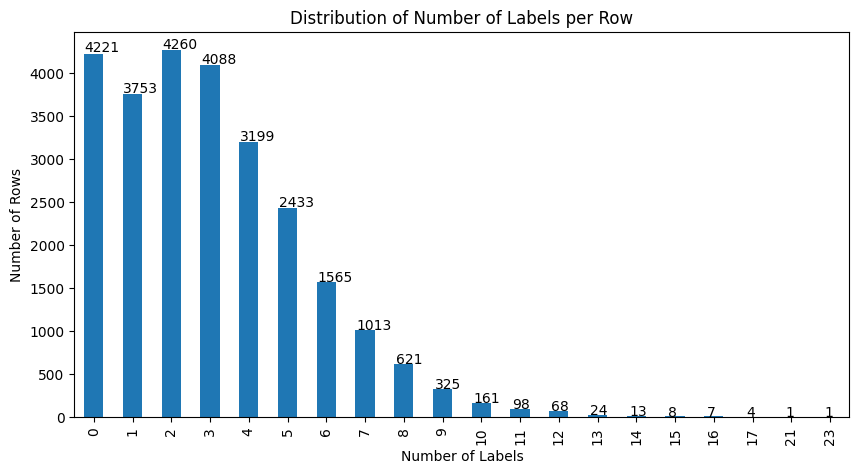

In [30]:
# Count the number of labels per row
label_counts_per_row = mtat.iloc[:,:-1].sum(axis=1)

# Count the frequency of rows with 'n' labels
rows_with_n_labels = label_counts_per_row.value_counts().sort_index()

# Plotting the distribution of 'n' labels
plt.figure(figsize=(10, 5))
bars = rows_with_n_labels.plot(kind='bar')
plt.title('Distribution of Number of Labels per Row')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Rows')

# Add text annotations
for p in bars.patches:
    bars.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [31]:
# Calculate the sum of labels for each row
row_label_sum = mtat.iloc[:, :-1].sum(axis=1) 

# Filter rows where the sum of labels is zero
rows_with_no_labels = mtat[row_label_sum == 0]
rows_with_no_labels

,singer,duet,plucking,world,bongos,harpsichord,sitar,chorus,female opera,clarinet,...,soft,noise,choir,rap,hiphop,water,baroque,fiddle,english,filepath
6,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/c/lvx_nova-lvx_nova-01-contimune-175-204.mp3
9,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/0/american_bach_soloists-j_s__bach__canta...
13,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/f/the_headroom_project-jetuton_andawai-01...
25,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/9/american_bach_soloists-heinrich_schutz_...
26,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/9/american_bach_soloists-heinrich_schutz_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25812,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/9/american_baroque-dances_and_suites_of_r...
25823,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/8/jacob_heringman-blame_not_my_lute-34-th...
25832,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/3/musica_franca-boismortier__sonatas_for_...
25833,False,0,0,0,0,False,0,0,0,0,...,0,0,False,0,0,0,0,0,0,mtat/3/musica_franca-boismortier__sonatas_for_...


In [32]:
# delete 4421 rows with 0 label
mtat = mtat[row_label_sum != 0]

In [33]:
mtat.shape

(21642, 135)

Checking the distribution of label

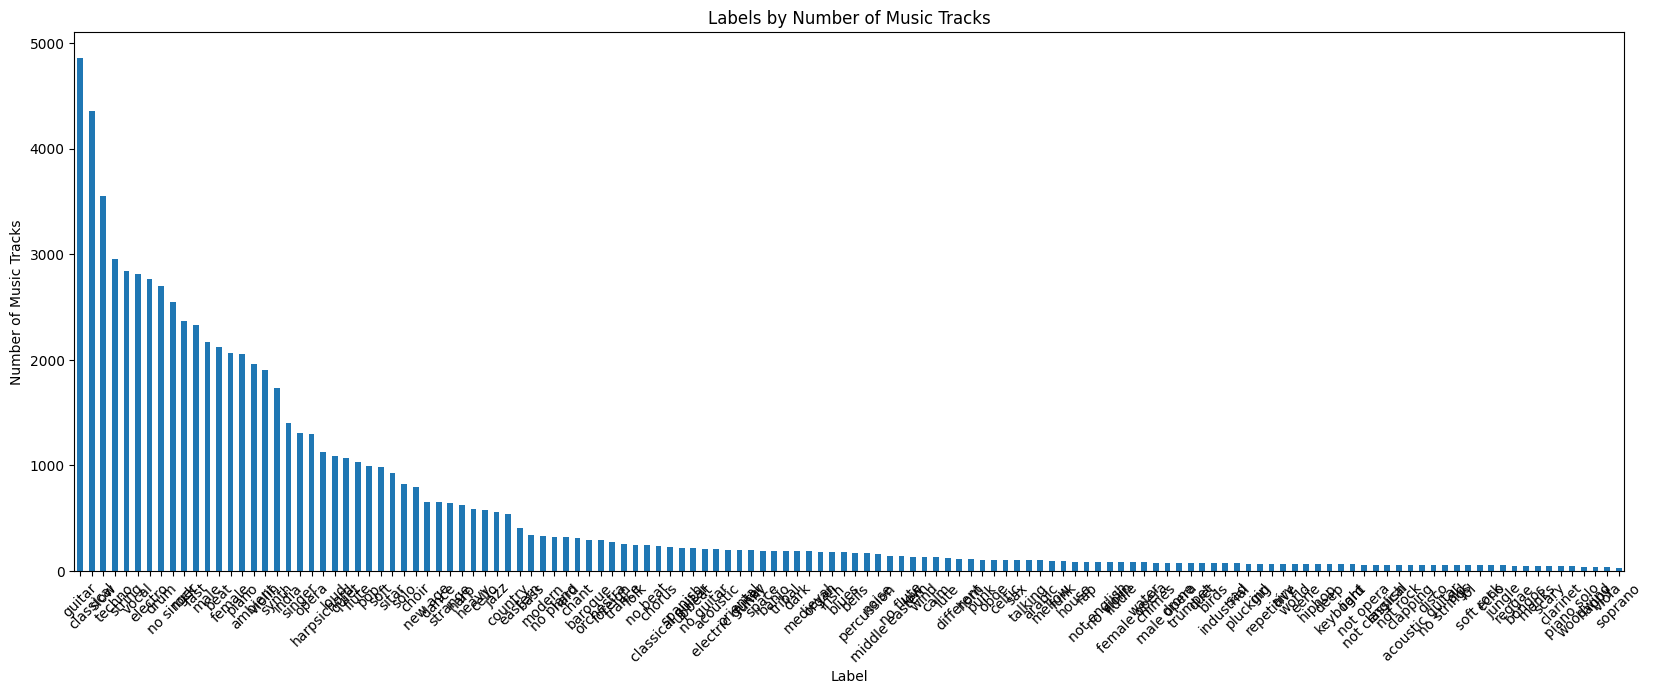

In [34]:
# Count the number of rows with each label
label_counts = mtat.iloc[:,:-1].sum(axis=0)
# Plot only the top 20 most common labels
# top_label_counts = label_counts.nlargest(50)

plt.figure(figsize=(20, 7))  # Adjust figure size as needed
bars = label_counts.sort_values(ascending=False).plot(kind='bar')  

plt.title('Labels by Number of Music Tracks')
plt.xticks(rotation=45)  # A slight rotation can sometimes help with readability
plt.ylabel('Number of Music Tracks')
plt.xlabel('Label')

plt.show()


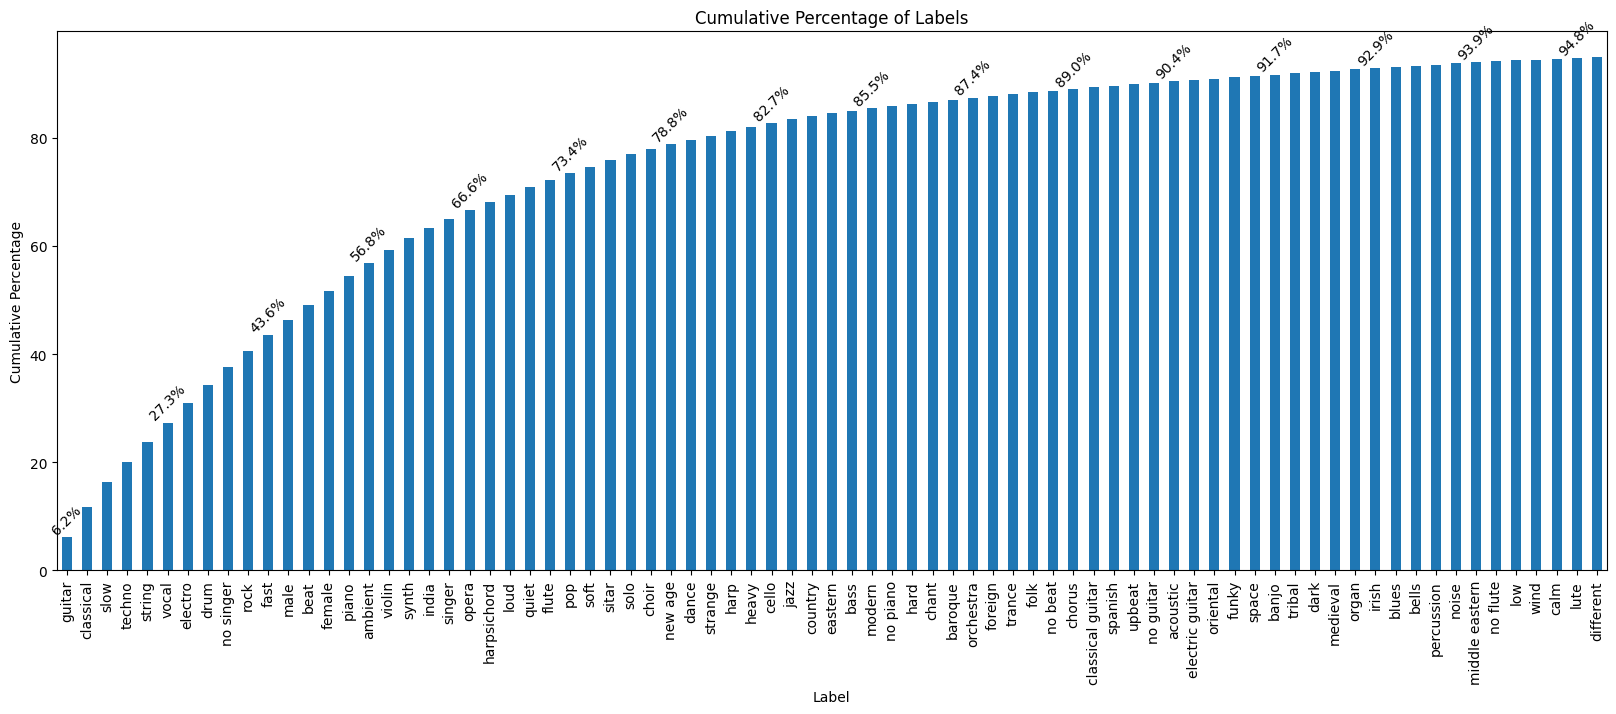

In [35]:
# Calculate cumulative percentage of the total labels
label_counts_sorted = label_counts.sort_values(ascending=False)
cumulative_percentage = label_counts_sorted.cumsum() / label_counts_sorted.sum() * 100

# Find the last index where cumulative percentage is less than or equal to 80
last_index = cumulative_percentage[cumulative_percentage <= 95].last_valid_index()

# Slice the cumulative_percentage to include only up to the last index where cumulative percentage is less than or equal to 80
cumulative_percentage_limited = cumulative_percentage.loc[:last_index]

plt.figure(figsize=(20, 7))  # Adjust figure size as needed
cumulative_percentage_limited.plot(kind='bar')

plt.title('Cumulative Percentage of Labels')
plt.xticks(rotation=90)  # Rotate the labels for better visibility
plt.ylabel('Cumulative Percentage')
plt.xlabel('Label')

# Add the cumulative percentage text above every 5 bars
for i, value in enumerate(cumulative_percentage_limited):
    if i % 5 == 0:  # Only label every 5th bar
        plt.text(i, value, f"{value:.1f}%", ha='center', va='bottom', rotation=45)


# Show the plot
plt.show()

In [36]:
# Check how many label it takes to reach 80% of the total count
for i in [80,85,90,95,98,99]:
    print(f'{i}% : {cumulative_percentage[cumulative_percentage<i].count()} labels')

80% : 32 labels
85% : 39 labels
90% : 54 labels
95% : 77 labels
98% : 104 labels
99% : 117 labels


In [37]:
# Find the last index where cumulative percentage is less than or equal to 95
last_index = cumulative_percentage[cumulative_percentage <= 95].last_valid_index()
# Slice the cumulative_percentage to include only up to the last index where cumulative percentage is less than or equal to 90
cumulative_percentage_limited = cumulative_percentage.loc[:last_index]

# First, we find the labels that make up to 80% of the cumulative percentage.
mtat_95 = cumulative_percentage_limited.index.tolist()
mtat_5 = cumulative_percentage.loc[last_index:].index.tolist()

# Display the list of labels outside of the top 90%
print(f'labels_outside_90%', mtat_5)
print()
print(f'labels_upto_90%', mtat_95)

labels_outside_90% ['different', 'horn', 'punk', 'oboe', 'celtic', 'sax', 'talking', 'arabic', 'mellow', 'funk', 'house', 'rap', 'not english', 'no violin', 'fiddle', 'female opera', 'water', 'chimes', 'male opera', 'drone', 'trumpet', 'duet', 'birds', 'industrial', 'sad', 'plucking', 'girl', 'repetitive', 'airy', 'world', 'eerie', 'hiphop', 'deep', 'keyboard', 'light', 'not opera', 'not classical', 'english', 'not rock', 'clapping', 'acoustic guitar', 'disco', 'no strings', 'old', 'lol', 'soft rock', 'echo', 'jungle', 'reggae', 'bongos', 'monks', 'scary', 'clarinet', 'piano solo', 'woodwind', 'happy', 'viola', 'soprano']

labels_upto_90% ['guitar', 'classical', 'slow', 'techno', 'string', 'vocal', 'electro', 'drum', 'no singer', 'rock', 'fast', 'male', 'beat', 'female', 'piano', 'ambient', 'violin', 'synth', 'india', 'singer', 'opera', 'harpsichord', 'loud', 'quiet', 'flute', 'pop', 'soft', 'sitar', 'solo', 'choir', 'new age', 'dance', 'strange', 'harp', 'heavy', 'cello', 'jazz', 'cou

In [38]:
# mtat_filtered = mtat.loc[mtat[mtat_95].sum(axis=1) >= 1, mtat_95 + ['filepath']]
# mtat_filtered.info()  # Display the info of the filtered dataframe to verify

#### Keep Top 50 labels only 

Literature suggests to keep only top 50 labels

In [39]:
label_counts = mtat.iloc[:, :-1].sum(axis=0)
label_counts_sorted = label_counts.sort_values(ascending=False) 
top_50_labels = label_counts_sorted.head(50).index

cumulative_percentage = label_counts_sorted.cumsum() / label_counts_sorted.sum() * 100
top_50_cumulative_percentage = cumulative_percentage.loc[top_50_labels]

filtered_mtat = mtat[top_50_labels].copy()
filtered_mtat[mtat.columns[-1]] = mtat[mtat.columns[-1]]  # keep the filepath col

In [40]:
# Save the results
labels_list = top_50_labels.tolist()  # Convert to list if it's a pandas Index

# Write the list to a file
with open('../data/top_50_labels.txt', 'w') as file:
    for label in labels_list:
        file.write(label + '\n')

In [41]:
print(mtat.shape)
print(filtered_mtat.shape)

(21642, 135)
(21642, 51)


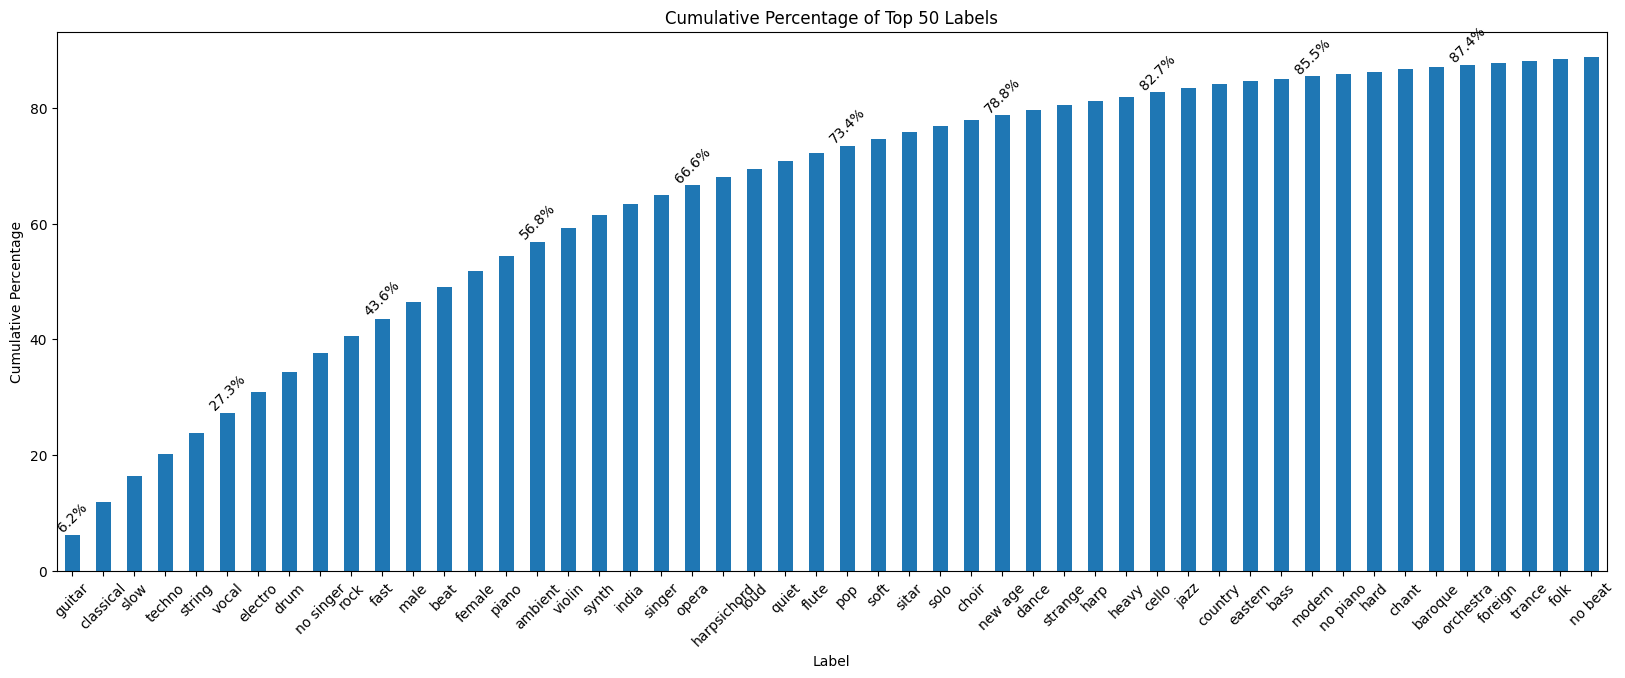

The top 50 labels account for 88.73% of the total distribution.


In [42]:
# Plotting the cumulative percentage of top 50 labels
plt.figure(figsize=(20, 7))
top_50_cumulative_percentage.plot(kind='bar')
plt.title('Cumulative Percentage of Top 50 Labels')
plt.xticks(rotation=45)
plt.ylabel('Cumulative Percentage')
plt.xlabel('Label')

# Adding text for cumulative percentage
for i, value in enumerate(top_50_cumulative_percentage):
    if i % 5 == 0:
        plt.text(i, value, f"{value:.1f}%", ha='center', va='bottom', rotation=45)

plt.show()

# Print the cumulative percentage of the top 50 labels
cumulative_percentage_top_50 = top_50_cumulative_percentage.iloc[-1]
print(f"The top 50 labels account for {cumulative_percentage_top_50:.2f}% of the total distribution.")

In [43]:
# Overwrite mtat for further processing
mtat = filtered_mtat

### Gtzan

In [44]:
gtzan = pd.read_csv('../data/gtzan_label.csv', index_col=0)

In [45]:
gtzan.head()

,filepath,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,gtzan/genres_original/blues/blues.00000.wav,True,False,False,False,False,False,False,False,False,False
1,gtzan/genres_original/blues/blues.00001.wav,True,False,False,False,False,False,False,False,False,False
2,gtzan/genres_original/blues/blues.00002.wav,True,False,False,False,False,False,False,False,False,False
3,gtzan/genres_original/blues/blues.00003.wav,True,False,False,False,False,False,False,False,False,False
4,gtzan/genres_original/blues/blues.00004.wav,True,False,False,False,False,False,False,False,False,False


In [46]:
gtzan = gtzan.loc[:, (gtzan != 0).any(axis=0)]

In [47]:
# check class imbalance
gtzan.sum(axis=0)

filepath     gtzan/genres_original/blues/blues.00000.wavgtz...
blues                                                      100
classical                                                  100
country                                                    100
disco                                                      100
hiphop                                                     100
jazz                                                       100
metal                                                      100
pop                                                        100
reggae                                                     100
rock                                                       100
dtype: object

## EDA for Audio

### Explore one sample

In [48]:
AUDIO_FILE = '../data/mtat/6/barry_phillips-trad-01-polska_fran_glava-0-29.mp3'
Audio(AUDIO_FILE)

In [49]:
waveform, sample_rate = audio_util.open(AUDIO_FILE) # returns tuple with waveform and sampling_rate
print(waveform.shape)
print(sample_rate)

torch.Size([1, 465984])
16000


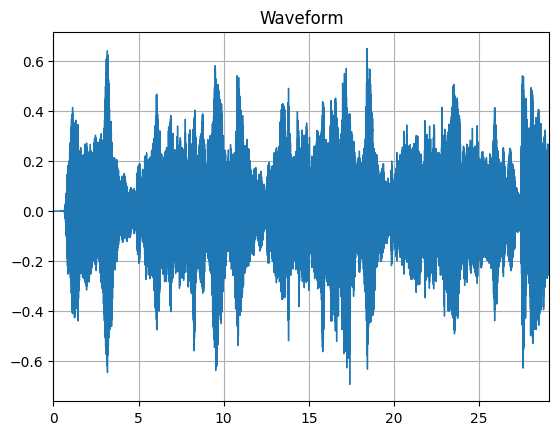

In [50]:
audio_util.plot_waveform(waveform, sample_rate)

In [51]:
# Get number of channels
num_channels = waveform.shape[0]  # The shape is (num_channels, num_samples)
print(f'Number of channels: {num_channels}')

Number of channels: 1


In [52]:
# Get the duration of the audio file
num_samples = waveform.shape[1]
print(f'Number of samples: {num_samples}')
duration_seconds = num_samples / sample_rate
print(f'Duration of audio: {duration_seconds}')

Number of samples: 465984
Duration of audio: 29.124


In [53]:
waveform_np = waveform.numpy()
spec = librosa.stft(waveform_np)
print(spec)
# librosa.display.specshow(spec)

[[[ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
    4.5375753e-10+0.0000000e+00j ...  1.2500306e+00+0.0000000e+00j
    3.4202516e-01+0.0000000e+00j  1.2314975e-02+0.0000000e+00j]
  [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
    3.7280676e-10+3.1208613e-10j ... -7.6994044e-01-6.0101694e-01j
    2.0648047e-02-2.9394984e-01j  7.9449778e-03-9.0857111e-03j]
  [ 0.0000000e+00-0.0000000e+00j  0.0000000e+00-0.0000000e+00j
    1.5517430e-10+5.4198840e-10j ...  1.4570209e-01+4.4440240e-01j
   -1.8204953e-01-3.7481416e-02j -1.3731896e-03-1.1539321e-02j]
  ...
  [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   -4.5603839e-15+1.2066364e-13j ... -3.4406381e-05-1.6710776e-06j
    1.3089869e-05+6.0190168e-06j  7.1701390e-07-9.2170006e-07j]
  [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   -6.6408393e-14+7.1032522e-14j ...  3.6789042e-05+7.3258602e-06j
    4.9676955e-06-1.9913026e-05j -1.3347276e-06-1.2532798e-06j]
  [ 0.0000000e+00+0.0000

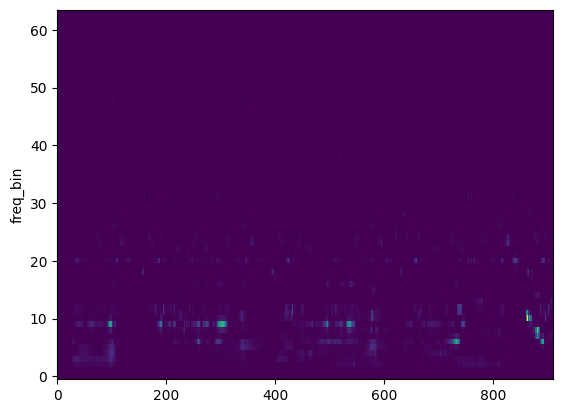

In [54]:
# Transform to mel spectrogram with amplitude domain
mel_spec_transformation = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=None, n_mels=64)
mel_spec = mel_spec_transformation(waveform)
audio_util.plot_spectrogram(mel_spec[0]) #TODO Fix Plotting of Amplitude Domain Spectrogram

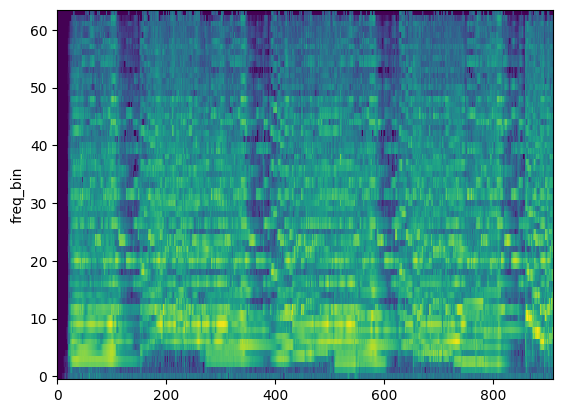

In [55]:
# Transform to mel spectrogram with decibals domain
transformation = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=None, n_mels=64),
    torchaudio.transforms.AmplitudeToDB(top_db=80)
)
mel_spec = transformation(waveform)
audio_util.plot_spectrogram(mel_spec[0])  # TODO FIX DB AXIS

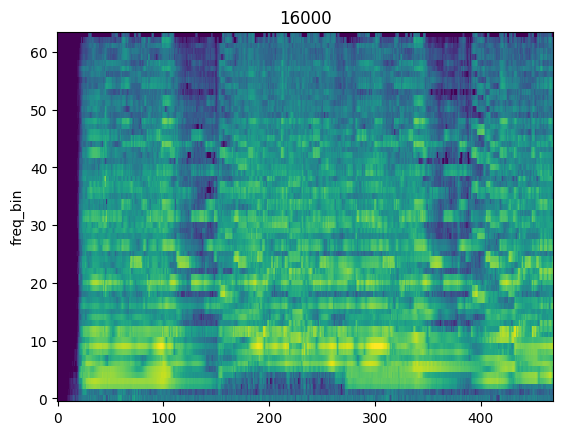

In [56]:
# Fixing time by truncating
waveform_trunc, sample_rate = audio_util.pad_or_trunc(waveform, sample_rate, max_s=15)

# Transform to mel spectrogram with decibals domain
transformation = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=None, n_mels=64),
    torchaudio.transforms.AmplitudeToDB(top_db=80)
)

mel_spec_trunc = transformation(waveform_trunc)
audio_util.plot_spectrogram(mel_spec_trunc[0], sample_rate)

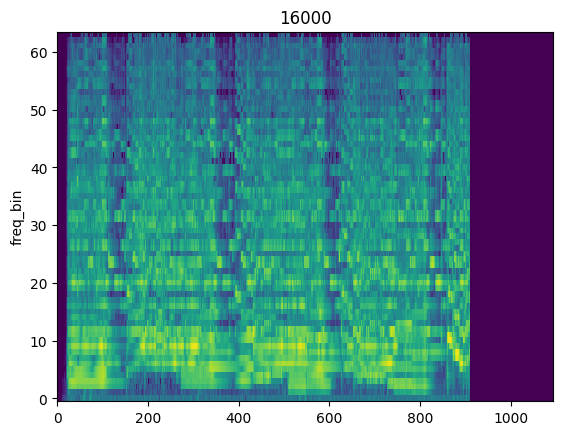

In [57]:
# audio_length < target length
waveform_pad, sample_rate = audio_util.pad_or_trunc(waveform, sample_rate, max_s=35)

# Transform to mel spectrogram with decibals domain
transformation = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=None, n_mels=64),
    torchaudio.transforms.AmplitudeToDB(top_db=80)
)

mel_spec_pad = transformation(waveform_pad)
audio_util.plot_spectrogram(mel_spec_pad[0], sample_rate)

### Iterate over mtat dat

In [58]:
def create_metadata_dataframe(df, data_path):
    label_df = df
    metadata = []  # List to store metadata of each file
    error_files = []  # List to store paths of problematic files

    # Iterate over the filepaths in the DataFrame
    for file in tqdm(label_df['filepath'], desc='Processing audio files'):
        try:
            # Construct the full file path for the audio file
            full_path = data_path + file

            # Use your audio_util class to open the audio file
            waveform, sample_rate = audio_util.open(full_path)
            num_channels = waveform.shape[0]

            # Duration
            num_samples = waveform.shape[1]
            audio_length = num_samples / sample_rate

# Create a dictionary of the data you want to store
            audio_info = {
                'filepath': file,
                'audio_channels': num_channels,
                'sample_rate': sample_rate,
                'audio_length': audio_length,
            }

            # Append the dictionary to the metadata list
            metadata.append(audio_info)

        except Exception as e:
            print(f"Failed to process {file}: {e}")
            error_files.append({'filepath': file})

    # Convert the lists of dictionaries to DataFrames
    metadata_df = pd.DataFrame(metadata)
    error_df = pd.DataFrame(error_files)

    return metadata_df, error_df

In [59]:
# get metadata and error df
metadata_mtat, errors_mtat = create_metadata_dataframe(mtat, '../data/')

Processing audio files:  62%|██████▏   | 13521/21642 [08:48<03:19, 40.80it/s]

Failed to process mtat/6/norine_braun-now_and_zen-08-gently-117-146.mp3: Failed to open the input "../data/mtat/6/norine_braun-now_and_zen-08-gently-117-146.mp3" (Invalid argument).


Processing audio files:  96%|█████████▌| 20797/21642 [13:15<00:22, 37.42it/s]

Failed to process mtat/8/jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3: Failed to open the input "../data/mtat/8/jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3" (Invalid argument).


Processing audio files:  99%|█████████▉| 21379/21642 [13:36<00:08, 32.84it/s]

Failed to process mtat/9/american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3: Failed to open the input "../data/mtat/9/american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3" (Invalid argument).


Processing audio files: 100%|██████████| 21642/21642 [13:45<00:00, 26.23it/s]


In [60]:
errors_mtat

,filepath
0,mtat/6/norine_braun-now_and_zen-08-gently-117-...
1,mtat/8/jacob_heringman-josquin_des_prez_lute_s...
2,mtat/9/american_baroque-dances_and_suites_of_r...


In [61]:
# delete those from the label data
error_file_set = set(errors_mtat['filepath'])
mtat = mtat[~mtat['filepath'].isin(error_file_set)]

In [62]:
# Print results
for col in metadata_mtat.columns.to_list():
    if col == 'filepath':
        continue
    print(metadata_mtat[col].value_counts())
    print()

audio_channels
1    21639
Name: count, dtype: int64

sample_rate
16000    21639
Name: count, dtype: int64

audio_length
29.124    21639
Name: count, dtype: int64



### Iterate over Gtzan data

In [63]:
metadata_gtzan, errors_gtzan = create_metadata_dataframe(gtzan, '../data/')

Processing audio files:  56%|█████▌    | 556/1000 [00:44<01:21,  5.48it/s]

Failed to process gtzan/genres_original/jazz/jazz.00054.wav: Failed to open the input "../data/gtzan/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).


Processing audio files: 100%|██████████| 1000/1000 [01:15<00:00, 13.17it/s]


In [64]:
errors_gtzan

,filepath
0,gtzan/genres_original/jazz/jazz.00054.wav


In [65]:
# delete those from the label data
error_file_set = set(errors_gtzan['filepath'])
gtzan = gtzan[~gtzan['filepath'].isin(error_file_set)]

In [66]:
# Print results
for col in metadata_gtzan.columns.to_list():
    if col == 'filepath':
        continue
    print(metadata_gtzan[col].value_counts())
    print()

audio_channels
1    999
Name: count, dtype: int64

sample_rate
22050    999
Name: count, dtype: int64

audio_length
30.013333    640
30.000181    295
30.648889     10
29.995828      5
30.007982      4
30.011791      4
30.171429      3
30.291156      3
30.370975      3
30.351020      3
30.241270      2
30.301134      2
30.081633      2
29.992925      2
30.091610      2
30.021769      1
30.480726      1
30.201361      1
30.271202      1
30.000000      1
30.400907      1
30.281179      1
29.931973      1
30.211338      1
30.131519      1
30.161451      1
30.121542      1
30.101587      1
29.981859      1
30.331066      1
30.071655      1
30.488980      1
30.390930      1
30.360998      1
Name: count, dtype: int64



## Train, Test Split

mtat

In [67]:

# Splitting the dataset into training and a (test + validation)
train_df, temp_test_df = train_test_split(mtat, test_size=0.4, random_state=42) # 60% for training, 40% for temp_test

# Splitting into validation and test sets
val_df, test_df = train_test_split(temp_test_df, test_size=0.5, random_state=42) # Splitting the 40% into two equal parts for val and test

# Now you have train (60%), validation (20%), and test (20%) sets
print(len(train_df), 'training examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')

12983 training examples
4328 validation examples
4328 test examples


In [68]:
# Write csvs
train_df.to_csv('../data/mtat_train_label.csv')
val_df.to_csv('../data/mtat_val_label.csv')
test_df.to_csv('../data/mtat_test_label.csv')

In [69]:
train_sums = train_df.sum()

In [70]:
val_sums = val_df.sum()

In [71]:
test_sums = test_df.sum()

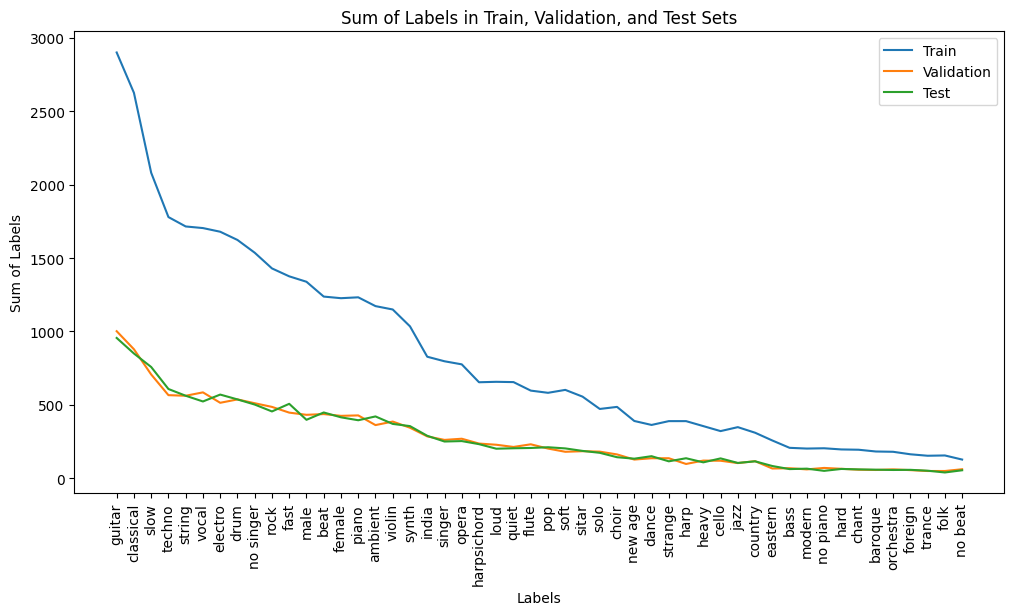

In [72]:

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(train_sums[:-1], label='Train')
plt.plot(val_sums[:-1], label='Validation')
plt.plot(test_sums[:-1], label='Test')

# Set the labels and title
plt.xlabel('Labels')
plt.ylabel('Sum of Labels')
plt.title('Sum of Labels in Train, Validation, and Test Sets')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend()

# Show the plot
plt.show()


gtzan

In [73]:

# Create a new column 'label' by extracting the label from one-hot encoding
gtzan['label'] = gtzan.iloc[:, 1:].idxmax(axis=1)

train_df, temp_test_df = train_test_split(gtzan, test_size=0.4, random_state=42, stratify=gtzan['label']) 
val_df, test_df = train_test_split(temp_test_df, test_size=0.5, random_state=42, stratify=temp_test_df['label']) 

print(len(train_df), 'training examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')
print()

print('label counts')
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

train_df.drop('label', axis=1, inplace=True)
val_df.drop('label', axis=1, inplace=True)
test_df.drop('label', axis=1, inplace=True)


599 training examples
200 validation examples
200 test examples

label counts
label
rock         60
metal        60
classical    60
blues        60
pop          60
reggae       60
disco        60
country      60
hiphop       60
jazz         59
Name: count, dtype: int64
label
classical    20
disco        20
reggae       20
pop          20
rock         20
hiphop       20
blues        20
jazz         20
country      20
metal        20
Name: count, dtype: int64
label
pop          20
country      20
hiphop       20
rock         20
jazz         20
disco        20
reggae       20
metal        20
classical    20
blues        20
Name: count, dtype: int64


In [78]:
# Write csvs
train_df.to_csv('../data/gtzan_train_label.csv')
val_df.to_csv('../data/gtzan_val_label.csv')
test_df.to_csv('../data/gtzan_test_label.csv')